In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean

%matplotlib inline
plt.rcParams["font.size"] = 14

In [8]:
def read_netcdf_xr(fid):
    ds = xr.open_mfdataset(fid, combine='by_coords')
    return ds

def plot_200_mask(axes, mask, bathy):
    '''function for plotting 200m isobath'''
    for ax in axes.flat:
        mask.plot.contour(ax=ax, x='nav_lon', y='nav_lat', linewidths=0.1, colors='k')
        bathy.Bathymetry.plot.contour(ax=ax, x='nav_lon', y='nav_lat', levels=[200], linewidths=1.1, colors='k')
    return

In [9]:
root_dir = '/home/gkara/Documents/for-tide_paper/'
_f = ['BISCAY-T60_1d_gridS_20110928-20110928.nc', 'BISCAY-T60_1d_gridS_20120224-20120224.nc']

# load S files -- TON
S_ref = read_netcdf_xr([root_dir + 'ref/' + f for f in _f])
S_ref = S_ref.set_coords(['nav_lon', 'nav_lat'])

# load T files -- TOFF
S_exp1 = read_netcdf_xr([root_dir + 'exp1/' + f for f in _f])
S_exp1 = S_exp1.set_coords(['nav_lon', 'nav_lat'])

# load bathymetry
bathy = read_netcdf_xr(root_dir + 'bathy_meter.nc')
bathy = bathy.set_coords(['nav_lon', 'nav_lat'])
land_mask = (bathy.Bathymetry > 0)

# select surface level and mask land
S_ref = S_ref.isel(deptht=0)
S_exp1 = S_exp1.isel(deptht=0)
S_ref = S_ref.where(land_mask)
S_exp1 = S_exp1.where(land_mask)

In [10]:
S_ref

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 2, x: 388, y: 538)
Coordinates:
    nav_lon               (y, x) float32 -11.68214 -11.654119 ... 0.23582333
    nav_lat               (y, x) float32 40.998505 40.99802 ... 50.905632
    deptht                float32 0.49402538
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2011-09-28T12:00:00 2012-02-24T12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds         (time_counter, axis_nbounds, y, x) float32 dask.array<chunksize=(1, 2, 538, 388), meta=np.ndarray>
    vosaline              (time_counter, y, x) float32 dask.array<chunksize=(1, 538, 388), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds, y, x) datetime64[ns] dask.array<chunksize=(1, 2, 538, 388), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds, y, x) datetime

/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/dask/core.py:119: Runt

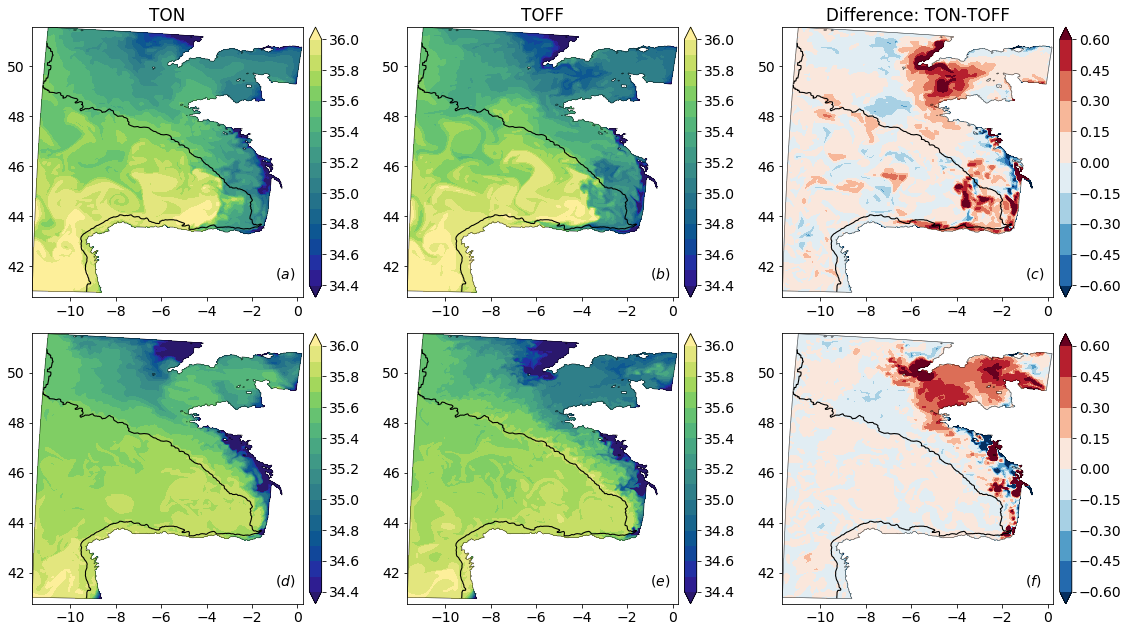

In [11]:
# compute difference: TON - TOFF
diff = S_ref - S_exp1
mask = np.isnan(S_ref.vosaline[0,:,:])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
for i in range(2):
    
    if i==0:
        vmin = 34.4
        vmax = 36
        levels = 17
        cbar_kwargs = {"label": '', "ticks":np.arange(vmin,vmax+1,0.2), "pad":0.02}
    else:
        vmin = 34.4
        vmax = 36
        levels = 17
        cbar_kwargs = {"label": '', "ticks":np.arange(vmin,vmax+1,0.2), "pad":0.02}
        
    S_ref.vosaline.isel(time_counter=i).plot.contourf(
        ax=axes[i, 0], x='nav_lon', y='nav_lat', levels=levels, vmin=vmin, vmax=vmax, cmap=cmocean.cm.haline,
        add_colorbar=True, extend='both', cbar_kwargs=cbar_kwargs)
    
    S_exp1.vosaline.isel(time_counter=i).plot.contourf(
    ax=axes[i, 1], x='nav_lon', y='nav_lat', levels=levels, vmin=vmin, vmax=vmax, cmap=cmocean.cm.haline,
    add_colorbar=True, extend='both', cbar_kwargs=cbar_kwargs)

    diff.vosaline.isel(time_counter=i).plot.contourf(
        ax=axes[i, 2], x='nav_lon', y='nav_lat', levels=9, vmin=-.6, vmax=.6, cmap='RdBu_r',
        add_colorbar=True, extend='both', cbar_kwargs={"label": '', "pad":0.02})

plot_200_mask(axes=axes, mask=mask, bathy=bathy)    

# annotate subplots
idx = ['$(a)$', '$(b)$', '$(c)$', '$(d)$', '$(e)$', '$(f)$']
for i, ax in enumerate(axes.flat):
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    ax.text(-1, 41.5, idx[i], size=14, weight='bold')

# set titles
axes[0, 0].set_title('TON')
axes[0, 1].set_title('TOFF')
axes[0, 2].set_title('Difference: TON-TOFF')

plt.tight_layout()

#save figure
fig.savefig('../_plots/figure5.png',dpi=300,bbox_inches='tight')